In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import re
import string

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from wordcloud import WordCloud

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

In [ ]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [ ]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(f'[{string.punctuation}]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    return ' '.join(tokens)

In [ ]:
df['message'] = df['message'].apply(preprocess_text)

In [ ]:
df['transformed_text'] = df['message'].apply(preprocess_text)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
print(df['label'].value_counts())

label
0    4825
1     747
Name: count, dtype: int64


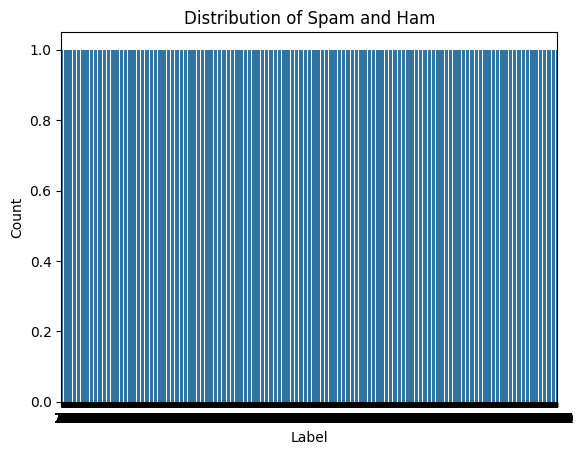

In [ ]:
sns.countplot(df['label'])
plt.title('Distribution of Spam and Ham')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='WHITE')


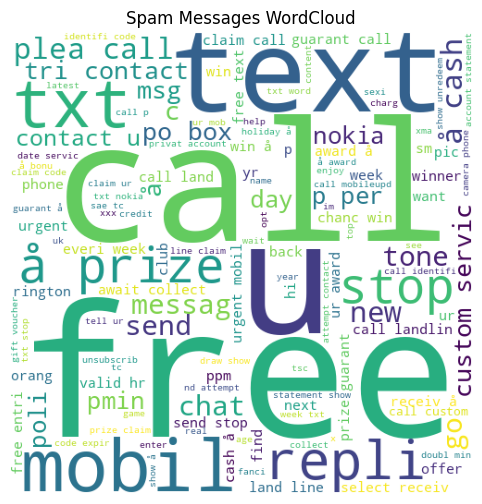

In [ ]:
spam_wc = wc.generate(df[df.label == 1]['transformed_text'].str.cat(sep=' '))
plt.figure(figsize=(12, 6))
plt.imshow(spam_wc)
plt.title('Spam Messages WordCloud')
plt.axis('off')
plt.show()

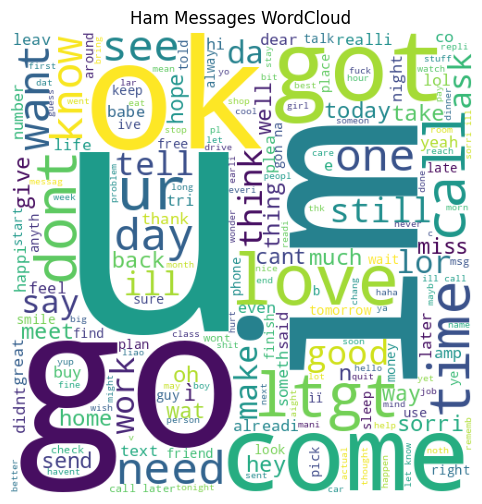

In [ ]:
ham_wc = wc.generate(df[df.label == 0]['transformed_text'].str.cat(sep=' '))
plt.figure(figsize=(12, 6))
plt.imshow(ham_wc)
plt.title('Ham Messages WordCloud')
plt.axis('off')
plt.show()

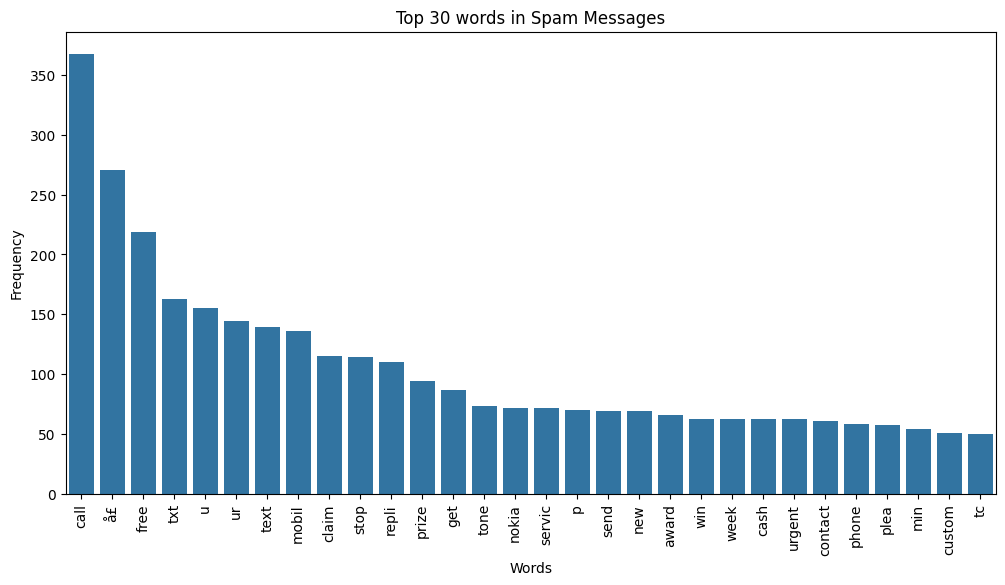

In [ ]:
y = {}
for msg in df[df.label == 1]['transformed_text'].tolist():
    for word in msg.split():
        y[word] = y.get(word, 0) + 1

sorted_y = sorted(y.items(), key=lambda x: x[1], reverse=True)
top_words = [item[0] for item in sorted_y[:30]]
word_counts = [item[1] for item in sorted_y[:30]]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words, y=word_counts)
plt.title('Top 30 words in Spam Messages')
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def plot_confusion_matrix_and_roc(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Model: Naive Bayes


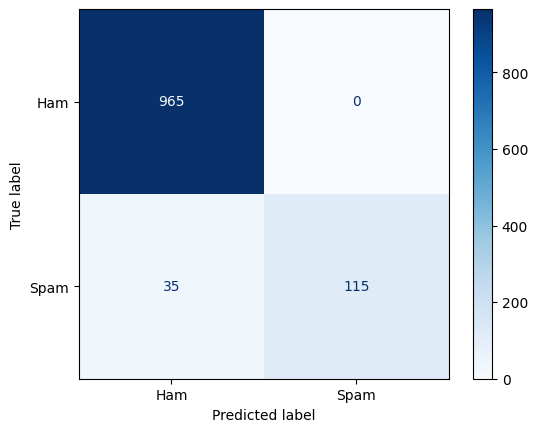

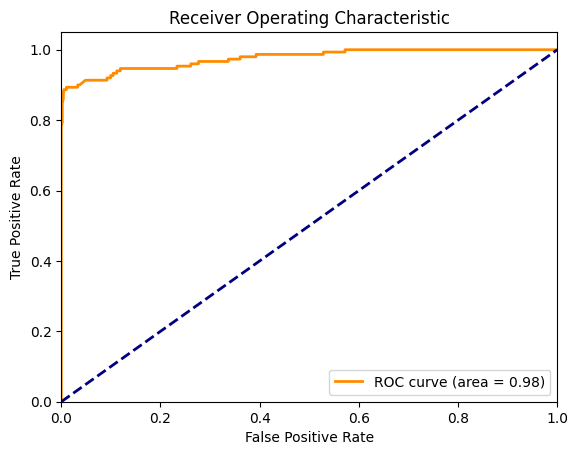

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("Model: Naive Bayes")
plot_confusion_matrix_and_roc(nb_model, X_test_tfidf, y_test)
print(classification_report(y_test, nb_model.predict(X_test_tfidf)))

Model: Logistic Regression


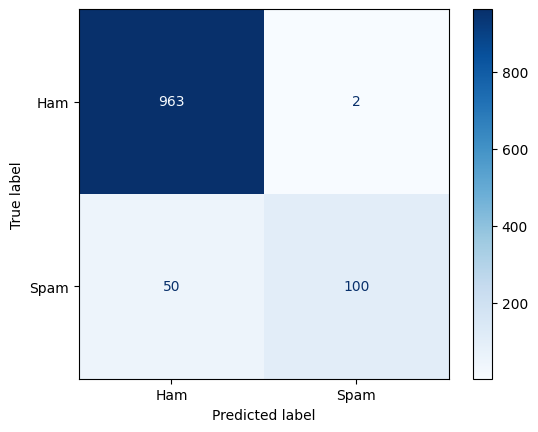

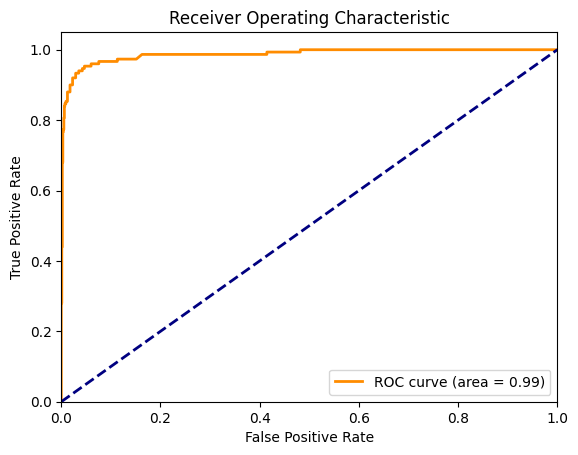

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.98      0.67      0.79       150

    accuracy                           0.95      1115
   macro avg       0.97      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115



In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
print("Model: Logistic Regression")
plot_confusion_matrix_and_roc(lr_model, X_test_tfidf, y_test)
print(classification_report(y_test, lr_model.predict(X_test_tfidf)))

Model: SVM


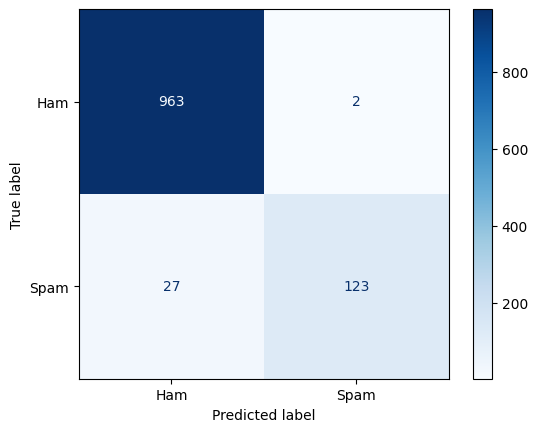

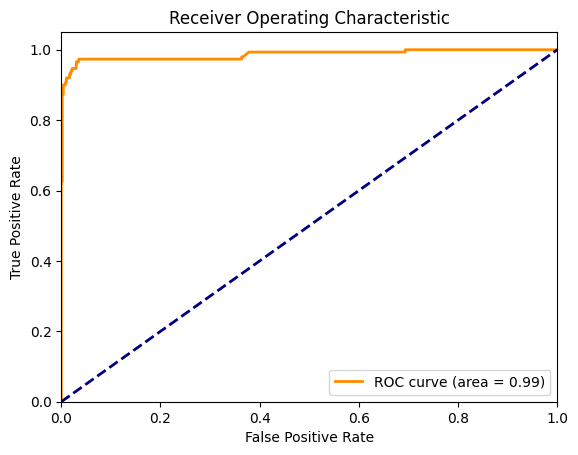

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.98      0.82      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [ ]:
svm_model = SVC(probability=True)
svm_model.fit(X_train_tfidf, y_train)
print("Model: SVM")
plot_confusion_matrix_and_roc(svm_model, X_test_tfidf, y_test)
print(classification_report(y_test, svm_model.predict(X_test_tfidf)))